In [4]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers, losses, models
from tensorflow.python.keras import metrics
from tensorflow.python.keras import backend as K
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import rcParams
import cv2
import random
from segmentation_models.metrics import iou_score, get_iou_score, f_score
from segmentation_models.losses import dice_loss, jaccard_loss
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.python.keras.optimizers import Adam
from keras.models import load_model
import pickle
from sklearn.model_selection import KFold

Using TensorFlow backend.
C:\Users\alessandra\Anaconda3\envs\PythonGPU1\lib\site-packages\classification_models\resnext\__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [5]:
# Function to normalize the color of pictures for visualization
def norm_colors(x):
    x_norm = (x-x.min())/(x.max()-x.min())
    return x_norm

In [6]:
seed = 100
random.seed = seed
np.random.seed = seed
tf.seed = seed

## Definition of parameters and folder paths

In [7]:
image_size = 256
batch_size = 8
batch_size_val = 8

train_path = 'train_2018/'
test_path = 'test_2018/'

## Training Ids
train_ids = next(os.walk(os.path.join(train_path + 'images/all/')))[2]
train_ids = [os.path.splitext(x)[0] for x in train_ids]

## Test Ids
test_ids = next(os.walk(os.path.join(test_path + 'images/all/')))[2]
test_ids = [os.path.splitext(x)[0] for x in test_ids]

In [8]:
train_ids = np.asarray(train_ids)
test_ids = np.asarray(test_ids)

In [9]:
print(train_ids.shape, test_ids.shape)

(2328,) (256,)


## 3-fold cross validation: split of indexes

In [10]:
kf = KFold(n_splits=3, random_state = seed, shuffle = True)
kf.get_n_splits(train_ids)
print(kf)

KFold(n_splits=3, random_state=100, shuffle=True)


In [11]:
list_indexes = list(kf.split(train_ids))
train_indexes0, validation_indexes0 = list_indexes[0]
train_ids0 = train_ids[train_indexes0]
validation_ids0 = train_ids[validation_indexes0]

train_indexes1, validation_indexes1 = list_indexes[1]
train_ids1 = train_ids[train_indexes1]
validation_ids1 = train_ids[validation_indexes1]

train_indexes2, validation_indexes2 = list_indexes[2]
train_ids2 = train_ids[train_indexes2]
validation_ids2 = train_ids[validation_indexes2]

In [12]:
print(train_ids1.shape, validation_ids1.shape)

(1552,) (776,)


# Define own data generator class

In [13]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=batch_size, image_size=image_size):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, "images/all/", id_name + ".jpg")
        mask_path = os.path.join(self.path, "masks/all/", id_name) + "_attribute_pigment_network.png"
        #mask_path = os.path.join(self.path, "masks_ben/all", id_name) + "_segmentation.png"

        ## Reading Image
        image = cv2.imread(image_path, -1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = cv2.imread(mask_path, -1)
        mask = cv2.resize(mask, (self.image_size, self.image_size))
        mask = np.expand_dims(mask, axis=-1)
            
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

## Training and validation generators

In [47]:
train_gen = DataGen(train_ids1, train_path, batch_size=batch_size, image_size=image_size)
validation_gen = DataGen(validation_ids1, train_path, batch_size=batch_size_val, image_size=image_size)
test_gen = DataGen(test_ids, test_path, batch_size=batch_size, image_size=image_size)

In [19]:
x, y = validation_gen.__getitem__(0)
print(x.shape, y.shape)

(8, 256, 256, 3) (8, 256, 256, 1)


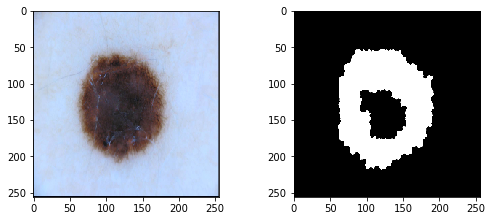

In [20]:
r = random.randint(0, len(x)-1)
fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow((x[r,:,:,:]))

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r]*255, (image_size, image_size)), cmap="gray")

# Define the convolutional blocks for the U-Net implementation

In [21]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [22]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0])
    c2, p2 = down_block(p1, f[1]) 
    c3, p3 = down_block(p2, f[2]) 
    c4, p4 = down_block(p3, f[3]) 
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3])
    u2 = up_block(u1, c3, f[2])
    u3 = up_block(u2, c2, f[1])
    u4 = up_block(u3, c1, f[0])
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

## Loss function: 0.5 dice_loss+ BCE

In [23]:
from keras.losses import binary_crossentropy
def dice_loss1(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = K.sum(intersection) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) -K.sum(y_true_f*y_pred_f)+ smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return (0.5*binary_crossentropy(y_true, y_pred) + dice_loss1(y_true, y_pred))

## Optimizer and metrics

In [24]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

Instructions for updating:
Colocations handled automatically by placer.


In [25]:
def iou_score_05(gt, pr, class_weights=1., smooth=1, per_image=True, threshold=0.5):
    if per_image:
        axes = [1, 2]
    else:
        axes = [0, 1, 2]
        
    if threshold is not None:
        pr = K.greater(pr, threshold)
        pr = K.cast(pr, K.floatx())

    intersection = K.sum(gt * pr, axis=axes)
    union = K.sum(gt + pr, axis=axes) - intersection
    iou = (intersection + smooth) / (union + smooth)

    # mean per image
    if per_image:
        iou = K.mean(iou, axis=0)

    # weighted mean per class
    iou_05 = K.mean(iou * class_weights)

    return iou_05

## Compile the model and load initial weights

In [26]:
model = UNet()
model.compile(loss=[bce_dice_loss], metrics=[iou_score_05, iou_score, f_score, 'accuracy'], optimizer= adam)
model.load_weights('20epochstrainonBenmasks.hdf5')

In [121]:
modelB = UNet()
modelB.compile(loss=bce_dice_loss, metrics=[iou_score_05, iou_score, f_score, 'accuracy'], optimizer= 'adam')
modelB.load_weights('20epochstrainonBenmasks.hdf5')

## Save the model

In [27]:
save_model_path ="tmp_simple/without_pretraining/Unet0-5bce+dice_loss-{epoch:02d}-{val_iou_score:.2f}.hdf5"
callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0.005, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.000001, verbose=1),
    ModelCheckpoint(filepath=save_model_path, monitor='val_iou_score', save_best_only=False, verbose=1)
]

### Fit the model

In [28]:
train_steps = len(train_ids1)//batch_size
validation_steps = len(validation_ids1)//batch_size_val
test_steps = len(test_ids) // batch_size

## CROSS VALIDATION

In [111]:
########## 1 TRIAL OF CROSS VALIDATION ####################
history_cv1 = model_cv1.fit_generator(train_gen, 
                              steps_per_epoch=train_steps,
                              epochs=50,
                              validation_data=validation_gen,
                              validation_steps=validation_steps,
                              verbose=1,
                              callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
97/97 [==============================] - 186s 2s/step - loss: 6.0642 - iou_score_05: 0.2688 - iou_score: 0.1384 - f_score: 0.2116 - acc: 0.9560

Epoch 00001: saving model to tmp_simple/definite08-06-2019/Unet0-5bce+dice_loss-crossval01-01-0.14.hdf5
194/194 [==============================] - 577s 3s/step - loss: 6.3539 - iou_score_05: 0.2415 - iou_score: 0.1262 - f_score: 0.1932 - acc: 0.9435 - val_loss: 6.0642 - val_iou_score_05: 0.2688 - val_iou_score: 0.1384 - val_f_score: 0.2116 - val_acc: 0.9560
Epoch 2/50
97/97 [==============================] - 196s 2s/step - loss: 5.8673 - iou_score_05: 0.2493 - iou_score: 0.1530 - f_score: 0.2295 - acc: 0.9446

Epoch 00002: saving model to tmp_simple/definite08-06-2019/Unet0-5bce+dice_loss-crossval01-02-0.15.hdf5
194/194 [==============================] - 558s 3s/step - loss: 6.1818 - iou_score_05: 0.2691 - iou_score: 0.1356 - f_score: 0.2048 - acc: 0.9467 - val_loss: 5.8673 - val_iou_s

In [195]:
########## 2 TRIAL OF CROSS VALIDATION ####################
history_cv2 = model_cv2.fit_generator(train_gen, 
                              steps_per_epoch=train_steps,
                              epochs=50,
                              validation_data=validation_gen,
                              validation_steps=validation_steps,
                              verbose=1,
                              callbacks=callbacks)

Epoch 1/50
97/97 [==============================] - 205s 2s/step - loss: 6.1416 - iou_score_05: 0.2434 - iou_score: 0.1384 - f_score: 0.2084 - acc: 0.9514

Epoch 00001: saving model to tmp_simple/definite08-06-2019/Unet0-5bce+dice_loss-crossval02-01-0.14.hdf5
194/194 [==============================] - 580s 3s/step - loss: 6.3068 - iou_score_05: 0.2490 - iou_score: 0.1343 - f_score: 0.2042 - acc: 0.9444 - val_loss: 6.1416 - val_iou_score_05: 0.2434 - val_iou_score: 0.1384 - val_f_score: 0.2084 - val_acc: 0.9514
Epoch 2/50
97/97 [==============================] - 217s 2s/step - loss: 6.0019 - iou_score_05: 0.2885 - iou_score: 0.1427 - f_score: 0.2140 - acc: 0.9503

Epoch 00002: saving model to tmp_simple/definite08-06-2019/Unet0-5bce+dice_loss-crossval02-02-0.14.hdf5
194/194 [==============================] - 585s 3s/step - loss: 6.0748 - iou_score_05: 0.2703 - iou_score: 0.1445 - f_score: 0.2167 - acc: 0.9485 - val_loss: 6.0019 - val_iou_score_05: 0.2885 - val_iou_score: 0.1427 - val_f_

In [248]:
########## 3 TRIAL OF CROSS VALIDATION ####################
history_cv3 = model_cv3.fit_generator(train_gen, 
                              steps_per_epoch=train_steps,
                              epochs=50,
                              validation_data=validation_gen,
                              validation_steps=validation_steps,
                              verbose=1,
                              callbacks=callbacks)

Epoch 1/50
97/97 [==============================] - 215s 2s/step - loss: 6.1772 - iou_score_05: 0.2648 - iou_score: 0.1277 - f_score: 0.1958 - acc: 0.9523

Epoch 00001: saving model to tmp_simple/definite08-06-2019/Unet0-5bce+dice_loss-crossval03-01-0.13.hdf5
194/194 [==============================] - 612s 3s/step - loss: 6.1820 - iou_score_05: 0.2461 - iou_score: 0.1395 - f_score: 0.2112 - acc: 0.9428 - val_loss: 6.1772 - val_iou_score_05: 0.2648 - val_iou_score: 0.1277 - val_f_score: 0.1958 - val_acc: 0.9523
Epoch 2/50
97/97 [==============================] - 225s 2s/step - loss: 6.2865 - iou_score_05: 0.2282 - iou_score: 0.1424 - f_score: 0.2117 - acc: 0.9370

Epoch 00002: saving model to tmp_simple/definite08-06-2019/Unet0-5bce+dice_loss-crossval03-02-0.14.hdf5
194/194 [==============================] - 593s 3s/step - loss: 5.9978 - iou_score_05: 0.2703 - iou_score: 0.1470 - f_score: 0.2205 - acc: 0.9473 - val_loss: 6.2865 - val_iou_score_05: 0.2282 - val_iou_score: 0.1424 - val_f_

## Test

In [333]:
########## test ####################
history_test = model_test.fit_generator(train_gen, 
                              steps_per_epoch=train_steps,
                              epochs=13,
                              validation_data=test_gen,
                              validation_steps=test_steps,
                              verbose=1,
                              callbacks=callbacks)

Epoch 1/13
32/32 [==============================] - 82s 3s/step - loss: 6.1659 - iou_score_05: 0.2435 - iou_score: 0.1257 - f_score: 0.1926 - acc: 0.9456

Epoch 00001: saving model to tmp_simple/definite08-06-2019/Unet0-5bce+dice_loss-test-01-0.13.hdf5
291/291 [==============================] - 658s 2s/step - loss: 6.2161 - iou_score_05: 0.2430 - iou_score: 0.1370 - f_score: 0.2076 - acc: 0.9436 - val_loss: 6.1659 - val_iou_score_05: 0.2435 - val_iou_score: 0.1257 - val_f_score: 0.1926 - val_acc: 0.9456
Epoch 2/13
32/32 [==============================] - 76s 2s/step - loss: 6.1391 - iou_score_05: 0.2382 - iou_score: 0.1289 - f_score: 0.1966 - acc: 0.9445

Epoch 00002: saving model to tmp_simple/definite08-06-2019/Unet0-5bce+dice_loss-test-02-0.13.hdf5
291/291 [==============================] - 656s 2s/step - loss: 6.0584 - iou_score_05: 0.2736 - iou_score: 0.1443 - f_score: 0.2158 - acc: 0.9485 - val_loss: 6.1391 - val_iou_score_05: 0.2382 - val_iou_score: 0.1289 - val_f_score: 0.1966 

In [225]:
########## no early stopping ####################
history2 = model2.fit_generator(train_gen, 
                              steps_per_epoch=train_steps,
                              epochs=50,
                              validation_data=validation_gen,
                              validation_steps=validation_steps,
                              verbose=1,
                              callbacks=callbacks)

Epoch 1/50
194/194 [==============================] - 230s 1s/step - loss: 3.1306 - iou_score_05: 0.2487 - iou_score: 0.1359 - f_score: 0.2065 - acc: 0.9447

Epoch 00001: saving model to tmp_simple/final_trial/Unet0-5bce+dice_loss-cv-01-01-0.14.hdf5
388/388 [==============================] - 604s 2s/step - loss: 3.2499 - iou_score_05: 0.2526 - iou_score: 0.1236 - f_score: 0.1905 - acc: 0.9452 - val_loss: 3.1306 - val_iou_score_05: 0.2487 - val_iou_score: 0.1359 - val_f_score: 0.2065 - val_acc: 0.9447
Epoch 2/50
194/194 [==============================] - 189s 974ms/step - loss: 3.1457 - iou_score_05: 0.2304 - iou_score: 0.1503 - f_score: 0.2228 - acc: 0.9433

Epoch 00002: saving model to tmp_simple/final_trial/Unet0-5bce+dice_loss-cv-01-02-0.15.hdf5
388/388 [==============================] - 556s 1s/step - loss: 3.1369 - iou_score_05: 0.2632 - iou_score: 0.1356 - f_score: 0.2057 - acc: 0.9471 - val_loss: 3.1457 - val_iou_score_05: 0.2304 - val_iou_score: 0.1503 - val_f_score: 0.2228 - v

## Without pre-training

In [31]:
history3 = model3.fit_generator(train_gen, 
                              steps_per_epoch=train_steps,
                              epochs=20,
                              validation_data=validation_gen,
                              validation_steps=validation_steps,
                              verbose=1,
                              callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
97/97 [==============================] - 217s 2s/step - loss: 7.4266 - iou_score_05: 0.3401 - iou_score: 0.0779 - f_score: 0.1225 - acc: 0.9553

Epoch 00001: saving model to tmp_simple/without_pretraining/Unet0-5bce+dice_loss-01-0.08.hdf5
194/194 [==============================] - 611s 3s/step - loss: 7.2764 - iou_score_05: 0.3499 - iou_score: 0.0669 - f_score: 0.1126 - acc: 0.9577 - val_loss: 7.4266 - val_iou_score_05: 0.3401 - val_iou_score: 0.0779 - val_f_score: 0.1225 - val_acc: 0.9553
Epoch 2/20
97/97 [==============================] - 194s 2s/step - loss: 6.9261 - iou_score_05: 0.2661 - iou_score: 0.0938 - f_score: 0.1492 - acc: 0.9440

Epoch 00002: saving model to tmp_simple/without_pretraining/Unet0-5bce+dice_loss-02-0.09.hdf5
194/194 [==============================] - 547s 3s/step - loss: 6.8746 - iou_score_05: 0.2722 - iou_score: 0.0970 - f_score: 0.1552 - acc: 0.9393 - val_loss: 6.9261 - val_iou_score_05: 0.2661 - va

## Save history and weights

In [32]:
model3.save_weights('20_epochs_no_pretraining.hdf5')

In [227]:
with open('./trainHistoryDict/history_20_epochs_no_pretraining', 'wb') as file_pi:
        pickle.dump(history3.history, file_pi)

## Open history

In [30]:
history_dict_cv00 = pickle.load(open('./trainHistoryDict/cv_history_00', 'rb'))

In [39]:
history_dict_cv01 = pickle.load(open('./trainHistoryDict/cv_history_01', 'rb'))

In [42]:
history_dict_cv02 = pickle.load(open('./trainHistoryDict/cv_history_02', 'rb'))

In [46]:
history_dict_test = pickle.load(open('./trainHistoryDict/cv_history_test', 'rb'))

In [112]:
history_dict_cv03 = {'loss': [6.1820, 
5.9978,
5.9554,
5.8689,
5.8328,
5.8679,
5.8355,
5.6262,
5.5303,
5.4878,
5.4314,
5.3770,
5.2960], 'val_loss' : [6.1772,
6.2865,
6.1593,
6.1411,
6.2018,
6.2743,
6.2577,
6.1217,
6.1205,
6.1599,
6.1635,
6.1484,
6.1557]}

## Predict the test data

In [59]:
x, y = validation_gen.__getitem__(20)
result = model3.predict(x)
#resultB = modelB.predict(x)
#resultB = resultB >0.5
result = result > 0.5

### Plot the results

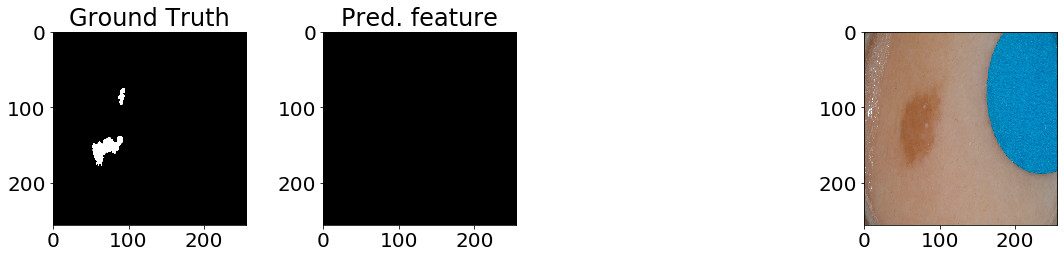

In [68]:
rcParams.update({'font.size': 20})
n= 1
fig = plt.figure(figsize=(18,6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 4, 1)
plt.title('Ground Truth')
ax.imshow(np.reshape(y[n]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 4, 2)
plt.title('Pred. feature')
ax.imshow(np.reshape(result[n]*255, (image_size, image_size)), cmap="gray")

#ax = fig.add_subplot(1, 4, 3)
#plt.title('Pred. segmentation')
#ax.imshow(np.reshape(resultB[n]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 4, 4)
ax.imshow(norm_colors(x[n]))
plt.savefig('Test_comparison2.png')

### Plot the history

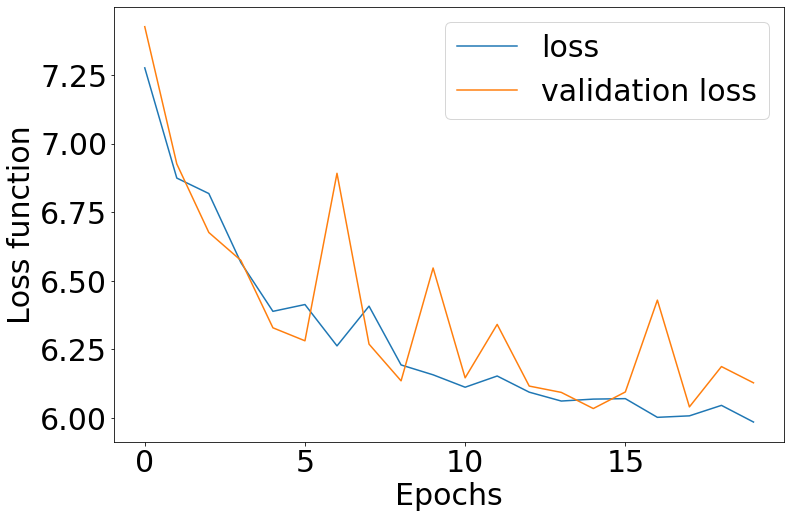

In [33]:
rcParams.update({'font.size': 30})
plt.figure(figsize=(12, 8))
plt.plot(history3.history["loss"], label="loss")
plt.plot(history3.history["val_loss"], label="validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss function")
plt.legend();
plt.savefig('20final_loss_function.png')

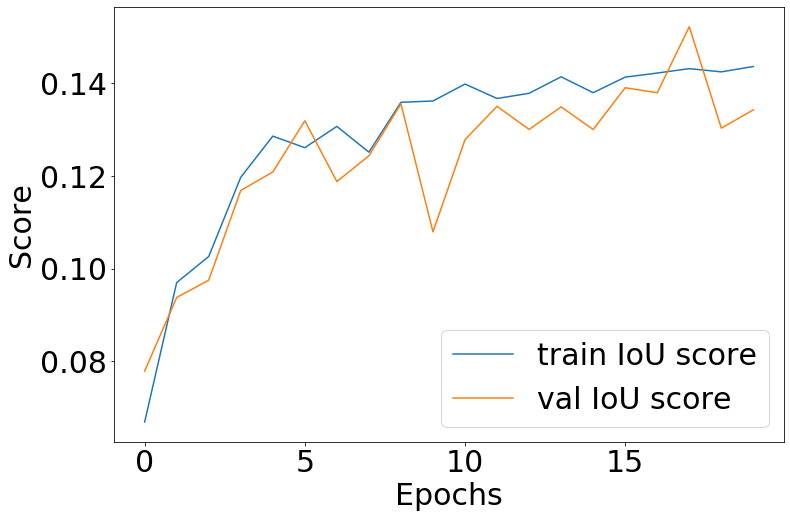

In [35]:
rcParams.update({'font.size': 30})
plt.figure(figsize=(12, 8))
#plt.title("Metrics: training with pretraining")
plt.plot(history3.history["iou_score"], label="train IoU score")
plt.plot(history3.history["val_iou_score"], label="val IoU score")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend();
plt.savefig('20final_score_0-5bce+dice_loss-test.png')

## Histogram for accuracy

<Figure size 864x576 with 0 Axes>

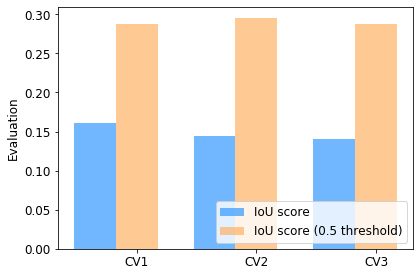

In [116]:
rcParams.update({'font.size': 12})
plt.figure(figsize=(12, 8))
# data to plot
n_groups = 3
IoU_score = (history_dict_cv00['val_iou_score'][-1], history_dict_cv01['val_iou_score'][-1], 0.1401)
IoU_score_thr =(history_dict_cv00['val_iou_score_05'][-1], history_dict_cv01['val_iou_score_05'][-1], 0.2870 )

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, IoU_score, bar_width,
alpha=0.7,
color='#3399FF',
label='IoU score')

rects2 = plt.bar(index + bar_width, IoU_score_thr, bar_width,
alpha=0.7,
color='#FFB266',
label='IoU score (0.5 threshold)')

plt.xlabel('')
plt.ylabel('Evaluation')
#plt.title('Scores by person')
plt.xticks(index + bar_width, ('CV1', 'CV2', 'CV3'))
plt.legend(loc=4)

plt.tight_layout()
plt.savefig('hist_evaluation_cross_validation.png')

## Plot the picture + mask

In [401]:
# if you want to load a picture and a mask
#src = cv2.imread("./train_2018/images/all/ISIC_0000001.jpg", -1)
#mask = cv2.imread("./train_2018/masks/all/ISIC_0000001_attribute_pigment_network.png", -1)

#if you already have numpy arrays (note that mask must be uint8)
src = x[n] #picture
mask = np.reshape(y[n]*255, (image_size, image_size)) #original mask
mask = mask.astype('uint8')

mask_pred = np.reshape(result[n]*255, (image_size, image_size)) #predicted mask
mask_pred = mask_pred.astype('uint8')

# find contours present in the mask
im2,contours,hierarchy = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
im3,contours2,hierarchy2 = cv2.findContours(mask_pred, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
# draw the found contours on to source image
for contour in contours:
    cv2.drawContours(src, contour, -1, (148,0,211), thickness = 1) # purple
for contour in contours2:
    cv2.drawContours(src, contour, -1, (0,128,128), thickness = 1) # cyan
    
# split source to R, G, B channels
r,g,b = cv2.split(src)

# merge the channels back together
final = cv2.merge((r,g,b), src)
#plt.figure(figsize=(12, 8))
#plt.imshow(final)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


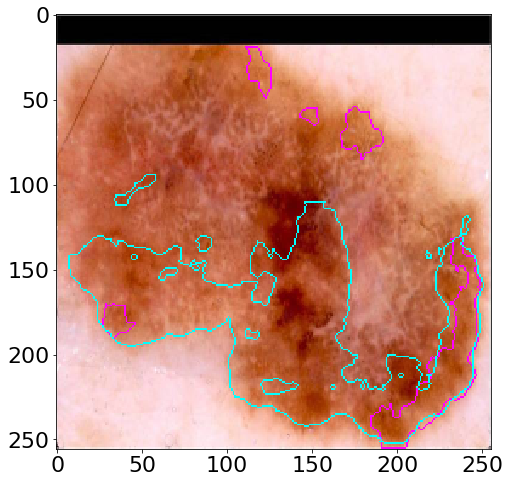

In [402]:
plt.figure(figsize=(8, 8))
plt.imshow(final)
plt.savefig('fig6_val_test.png')